# 演示从存储在磁盘上的纯文本文件开始的文本分类。训练一个二元分类器对 IMDB 数据集执行情感分析。

In [21]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

# 教程中的导入方法为
# from tensorflow.keras import layers
# from tensorflow.keras import losses
from tensorflow.python import keras
from keras import layers
from keras import losses

In [22]:
print(tf.__version__)

2.15.0


使用 Large Movie Review Dataset, 该数据集包含来自互联网电影数据库的文本影评，标记为正面或负面。

In [23]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

# 使用 keras.utils.get_file() 下载数据集并将其缓存到缓存目录中。
dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

# 为数据集创建一个根目录
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [24]:
os.listdir(dataset_dir)

['imdbEr.txt', 'test', 'imdb.vocab', 'README', 'train']

In [25]:
# 创建一个目录来存储训练和验证数据
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'neg',
 'urls_pos.txt',
 'unsup',
 'urls_neg.txt',
 'pos',
 'unsupBow.feat',
 'labeledBow.feat']

读取train_dir中的pos/1181_9.txt

In [26]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


# 加载数据集

In [27]:
# 由于只需要neg和pos
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir) # shutil.rmtree() 递归删除文件夹unsup 

# 拆分训练集创建验证集

In [28]:
batch_size = 32
seed = 42

# 使用validation_split和subset参数来分割训练集
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, # 以20%的数据作为验证集
    subset='training',  # 从训练集中取
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


# 遍历打印前三个样本

In [29]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

# 标签为 0 或 1。要查看它们与正面和负面电影评论的对应关系，可以查看数据集上的 class_names

In [30]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


# 创建验证数据集和测试数据集

In [31]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [32]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


# 准备用于训练的数据集

In [33]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data) # 小写
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ') # 去除html标签
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '') # 去除标点符号 tf.strings.regex_replace() 正则表达式替换 args: pattern, rewrite, input

# 接下来，您将创建一个 TextVectorization 层。您将使用该层对我们的数据进行标准化、词例化和向量化。您将 output_mode 设置为 int 以便为每个词例创建唯一的整数索引。

In [34]:
max_features = 10000 # 仅考虑前 10000 个词
sequence_length = 250 # 只考虑每个影评中的前 250 个词

# layer用于标准化、词例化和向量化 TextVectorization
# 文本数据向量化层
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization, # 标准化
    max_tokens=max_features, # 仅考虑前 10000 个词
    output_mode='int', # 为每个词例创建唯一的整数索引
    output_sequence_length=sequence_length)

# 接下来，您将调用 adapt 以使预处理层的状态适合数据集。这会使模型构建字符串到整数的索引。

In [35]:
# raw_train_ds中的数据是一个batch一个batch的，所以需要先将其转换为一个list
# 然后通过vectorize_layer.adapt()来适应数据集
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

# 创建一个函数来查看使用该层预处理一些数据的结果

In [37]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1) # tf.expand_dims() 给张量增加一个维度
  return vectorize_layer(text), label # vectorize_layer() 将文本转换为向量

In [38]:
# 从数据集中检索一个批次(包含32个评论和标签)
text_batch, label_batch = next(iter(raw_train_ds)) # iter() 创建一个迭代器 next() 返回迭代器的下一个项目
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Belmondo is a tough cop. He goes after a big-time drug dealer (played by Henry Silva, normally a great villain - see "Sharky\'s Machine"; but here he is clearly dubbed, and because of that he lacks his usual charisma). He goes to the scuzziest places of Paris and Marseilles, asks for some names, beats up some people, gets the names, goes to more scuzzy places, asks for more names, beats up more people, etc. The whole movie is punch after punch after punch. It seems that the people who made it had no other ambition than to create the French equivalent of "Dirty Harry". Belmondo, who was 50 here, does perform some good stunts at the beginning; apart from those, "Le Marginal" is a violent, episodic, trite, shallow and forgettable cop movie. (*1/2)', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   1,    7,    4, 1233, 1021,   27,  261,  101,    4,    1, 1525,
        6992,  248,   32, 1488,    1, 1659,    4,

In [39]:
# get_vocabulary() 返回词汇表
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287]) # 1287 --->  silent
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313]) #  313 --->  night
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary()))) # Vocabulary size: 10000

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


# 将之前创建的 TextVectorization 层应用于训练数据集、验证数据集和测试数据集

In [40]:
# 使用map() 每个样本都包括向量化后的文本数据和标签
print(raw_train_ds, type(raw_train_ds))
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))> <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


In [41]:
print(train_ds, type(train_ds))

<_MapDataset element_spec=(TensorSpec(shape=(None, 250), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))> <class 'tensorflow.python.data.ops.map_op._MapDataset'>


# 创建神经网络

In [43]:
embedding_dim = 16 # 词向量的维度

层按顺序堆叠以构建分类器：
第一个层是 Embedding 层。此层采用整数编码的评论，并查找每个单词索引的嵌入向量。这些向量是通过模型训练学习到的。向量向输出数组增加了一个维度。得到的维度为：(batch, sequence, embedding)。要详细了解嵌入向量，请参阅单词嵌入向量教程。  
接下来，GlobalAveragePooling1D 将通过对序列维度求平均值来为每个样本返回一个定长输出向量。这允许模型以尽可能最简单的方式处理变长输入。  
该定长输出向量通过一个有 16 个隐层单元的全连接（Dense）层传输。  
最后一层与单个输出结点密集连接。使用 Sigmoid 激活函数，其函数值为介于 0 与 1 之间的浮点数，表示概率或置信度。

In [44]:
# 使用 tf.keras.Sequential 搭建模型
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim), # 词嵌入层 词汇表大小为 10001（有 10000 个词 +1，未知词），词向量的维度为 16
  layers.Dropout(0.2), # 丢弃层 0.2代表丢弃20%的数据
  layers.GlobalAveragePooling1D(), # 全局平均池化层
  layers.Dropout(0.2), # 丢弃层
  layers.Dense(1)]) # 全连接层 1个神经元

model.summary() # 打印模型结构

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160033 (625.13 KB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
________________

# 损失函数与优化器

In [45]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True), # 二元交叉熵损失函数
              optimizer='adam', # 优化器 Adam 利用了动量方法，它有助于加速梯度下降在相关方向上的收敛，并减少震荡
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0)) # 二元准确率

# 训练模型

In [46]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 2s 3ms/step - loss: 0.6647 - binary_accuracy: 0.6918 - val_loss: 0.6152 - val_binary_accuracy: 0.7732
Epoch 2/10
625/625 [==============================] - 2s 4ms/step - loss: 0.5487 - binary_accuracy: 0.8033 - val_loss: 0.4986 - val_binary_accuracy: 0.8222
Epoch 3/10
625/625 [==============================] - 2s 4ms/step - loss: 0.4454 - binary_accuracy: 0.8439 - val_loss: 0.4204 - val_binary_accuracy: 0.8468
Epoch 4/10
625/625 [==============================] - 2s 4ms/step - loss: 0.3790 - binary_accuracy: 0.8655 - val_loss: 0.3740 - val_binary_accuracy: 0.8602
Epoch 5/10
625/625 [==============================] - 2s 4ms/step - loss: 0.3356 - binary_accuracy: 0.8794 - val_loss: 0.3448 - val_binary_accuracy: 0.8688
Epoch 6/10
625/625 [==============================] - 2s 4ms/step - loss: 0.3048 - binary_accuracy: 0.8889 - val_loss: 0.3261 - val_binary_accuracy: 0.8702
Epoch 7/10
625/625 [==============================] - 3s 4ms/ste

# 评估模型

In [47]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 1s 1ms/step - loss: 0.3098 - binary_accuracy: 0.8741
Loss:  0.30984339118003845
Accuracy:  0.8740800023078918


# 创建准确率和损失随时间变化的图表

In [48]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

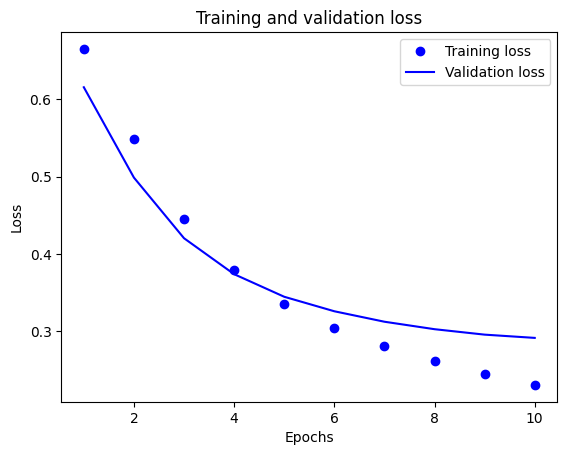

In [49]:
acc = history_dict['binary_accuracy'] # 二元准确率
val_acc = history_dict['val_binary_accuracy'] # 验证集二元准确率
loss = history_dict['loss'] # 损失
val_loss = history_dict['val_loss'] # 验证集损失

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

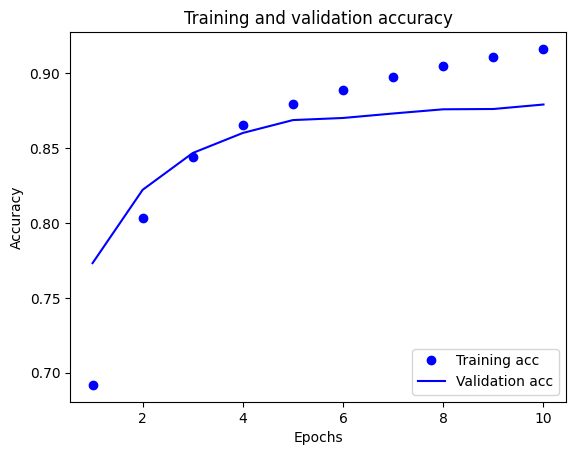

In [50]:
# 绘制准确率
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# 导出模型

In [51]:
# vectorize_layer：这通常是一个将文本转换为固定大小的数值向量的层。
# model：这是已经训练好的模型，负责进行实际的预测。
# layers.Activation('sigmoid')：在输出层使用 Sigmoid 激活函数，将输出转换为介于 0 和 1 之间的概率值，通常用于二分类任务。
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), 
    optimizer="adam", 
    metrics=['accuracy']
)

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 1s 2ms/step - loss: 0.3098 - accuracy: 0.8741
0.8740800023078918


# 使用新数据推断

In [52]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 53ms/step


array([[0.6218485 ],
       [0.44370332],
       [0.36250514]], dtype=float32)

# 练习:  
## 对 Stack Overflow 问题进行多类分类  
数据集地址：https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz  
```bash
wget https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz
tar -xzf stack_overflow_16k.tar.gz
```
## 任务
每一个问题都只有一个标签（Python、CSharp、JavaScript 或 Java）。您的任务是将问题作为输入，并预测适当的标签，在本例中为 Python。  

# 练习见./stack_overflow_classification.py